In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-clustering/segmentation data.csv
/kaggle/input/customer-clustering/segmentation data legend.xlsx


<a id="1"></a> <br>
# 1. Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id="1"></a> <br>
# 2. Import Dataset

In [3]:
data = pd.read_csv('/kaggle/input/customer-clustering/segmentation data.csv')

<a id="1"></a> <br>
# 3. Customer Segmentation Model

| Variable | Data Type | Range | Description |
| --- | --- | --- | --- |
| ID | numerical | Integer | Shows a unique identificator of a customer. |
| Sex | categorical | {0,1} | Biological sex (gender) of a customer. 0 = male / 1 = female |
| Marital status | categorical | {0,1} | Marital status of a customer. 0 = single / 1 = non-single |
| Age | numerical | Integer | The age of the customer in years, calculated as current year minus the year of birth of the customer at the time of creation of the dataset (Min. age = 18 / Max. age = 78) |
| Education | categorical | {0,1,2,3} | Level of education of the customer. 0=no education / 1=high-school / 2=university / 3=graduate |
| Income | numerical | Real | Self-reported annual income in US dollars of the customer. |
| Occupation | categorical | {0,1,2} | Category of occupation of the customer. 0=unemployed / 1=employee/oficial / 2=management or self-employed |
| Settlement size | categorical | {0,1,2} | The size of the city that the customer lives in. 0=small / 1=mid-size / 2=big |

In [4]:
data.sample(10)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
1564,100001565,1,0,23,1,115499,1,0
1811,100001812,0,0,40,1,72193,0,0
1017,100001018,0,0,68,2,135705,1,1
1356,100001357,1,0,42,1,110509,1,0
874,100000875,0,0,29,0,87598,0,2
1784,100001785,0,0,26,0,124783,1,0
1037,100001038,0,0,63,2,273063,2,2
95,100000096,0,0,58,2,268340,1,1
1946,100001947,0,0,40,1,76881,0,0
1666,100001667,0,1,30,1,106597,1,0


In [5]:
# checking missing values:
data.isnull().sum()

ID                 0
Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [6]:
# checking nunique and type per columns:
df_nunique = pd.DataFrame([[col , data[col].nunique(),data[col].dtypes] for col in data.columns],columns=['col','nunique','type'])
df_nunique

,col,nunique,type
0,ID,2000,int64
1,Sex,2,int64
2,Marital status,2,int64
3,Age,58,int64
4,Education,4,int64
5,Income,1982,int64
6,Occupation,3,int64
7,Settlement size,3,int64


In [7]:
num_columns = ['ID','Age','Income']
cat_columns = ['Sex','Marital status','Education','Occupation','Settlement size']
data[cat_columns] = data[cat_columns].astype('str')

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2000.0,1.000010e+08,577.494589,100000001.0,1.000005e+08,100001000.5,1.000015e+08,100002000.0
Age,2000.0,3.590900e+01,11.719402,18.0,2.700000e+01,33.0,4.200000e+01,76.0
Income,2000.0,1.209544e+05,38108.824679,35832.0,9.766325e+04,115548.5,1.380722e+05,309364.0


In [9]:
data.describe(include='object').T

,count,unique,top,freq
Sex,2000,2,0,1086
Marital status,2000,2,0,1007
Education,2000,4,1,1386
Occupation,2000,3,1,1113
Settlement size,2000,3,0,989


<a id="1"></a> <br>
# 4. Exploratory Data Analysis

Take a look at the distributions of the numerical variables Age, ID and Income:




ID has a uniform distribution, which makes sense since it is an identifier of the customer and it will be dropped.

The variable 'Age' has a heavy right skew, generated because of the lower limit at zero of the variable. If we are using K-Means clustering, there will be no need to normalize the feature, but we may have to do so for other models.

The feature 'Income' has the same right skew problem as the 'Age' feature. We'll have to be wary of this depending on the model we select.


**Numerical Variables Distribution:**

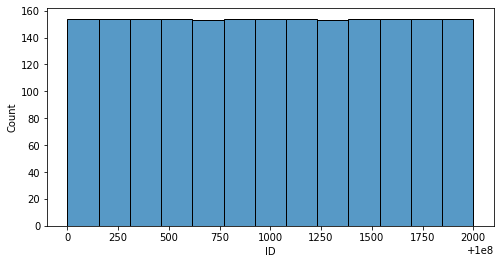

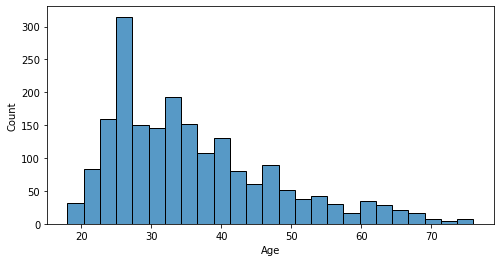

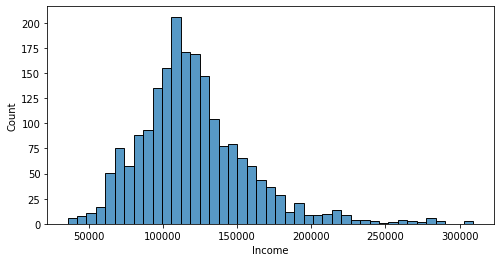

In [10]:
for col in num_columns:
    plt.figure(figsize=(8,4))
    sns.histplot(data =data, x=col)

Take a look at the distributions of the categorical variables:

* Customer genders are quite balanced.

* Marital status is also balanced.

* Most customers have highschool level education. There are only 1,8% graduate students. We could join both categories ('2' and '3') in a category called university & over.

* Both the 'Occupation' and 'Settlement size' features seem to have a larger enough quantity of instances of each category.


**categorical Variables Distribution:**

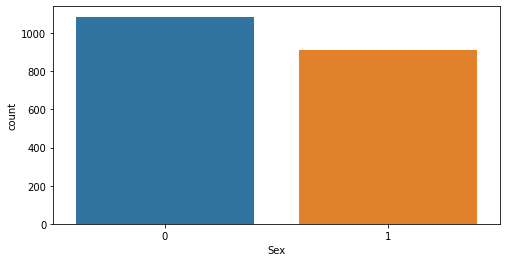

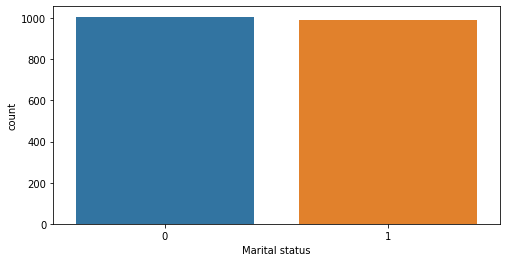

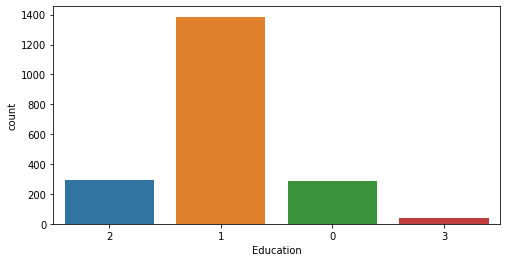

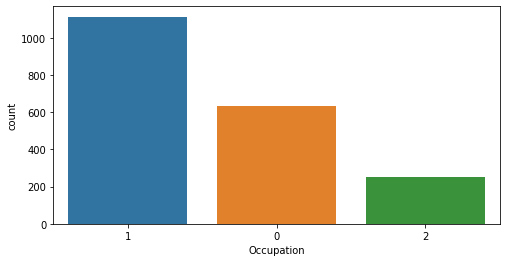

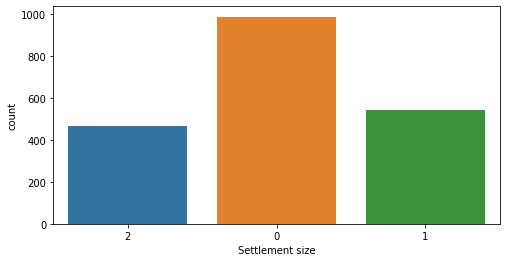

In [11]:
for col in cat_columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data =data, x=col)

**Categorical vs Numerical:**

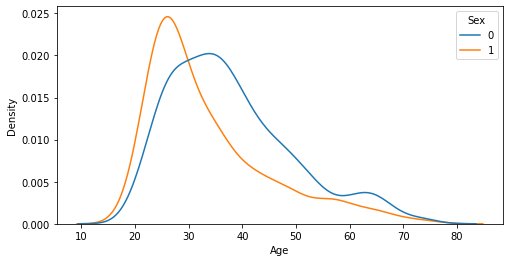

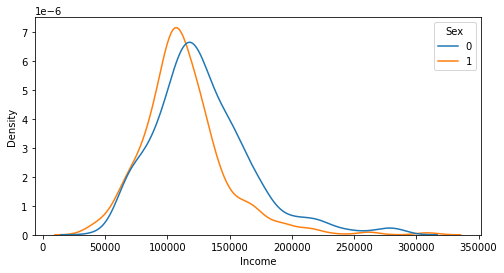

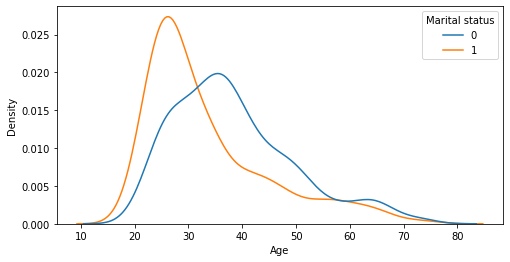

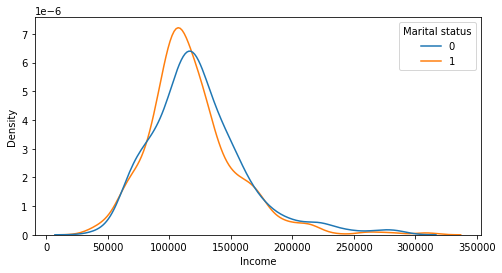

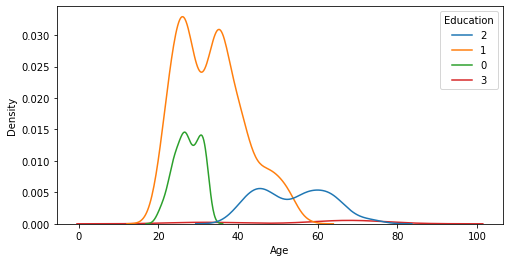

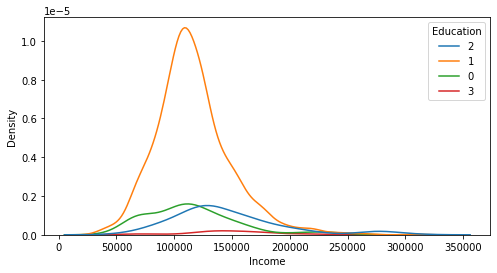

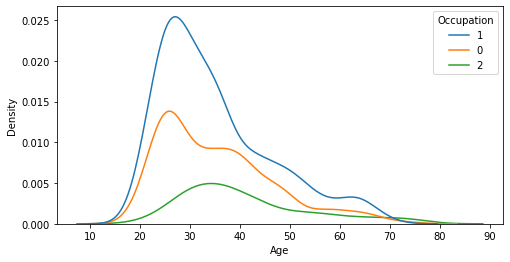

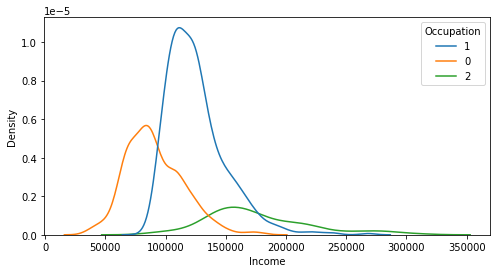

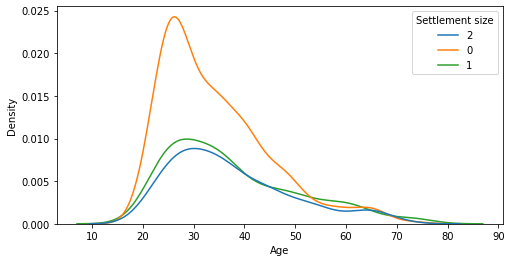

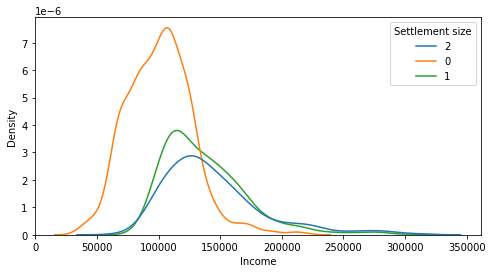

In [12]:
for col_cat in cat_columns:
    for col_num in num_columns:
        if col_num != 'ID':
            plt.figure(figsize=(8,4))
            sns.kdeplot(data=data, x=col_num, hue=col_cat)

**Categorical vs Categorical:**

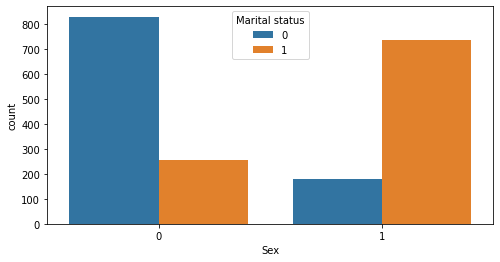

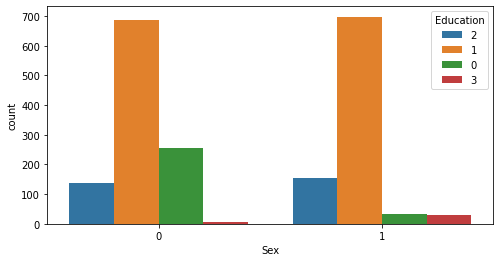

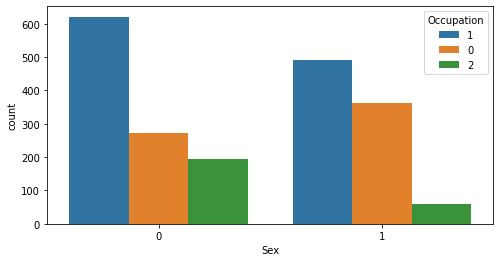

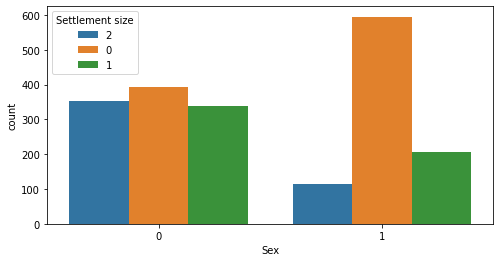

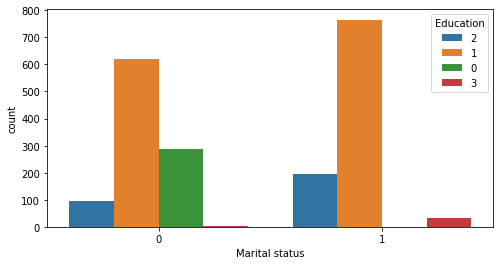

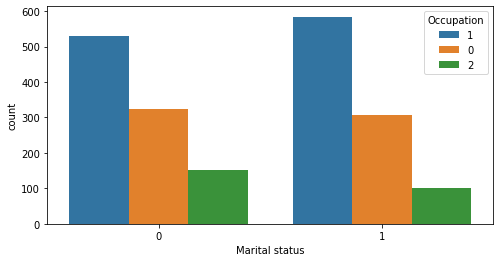

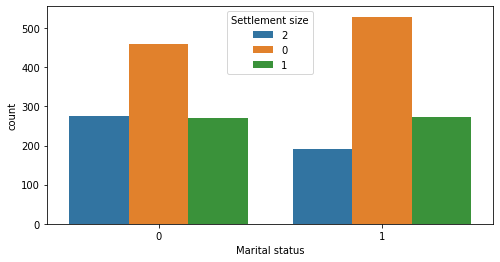

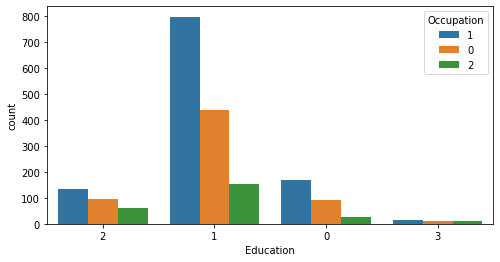

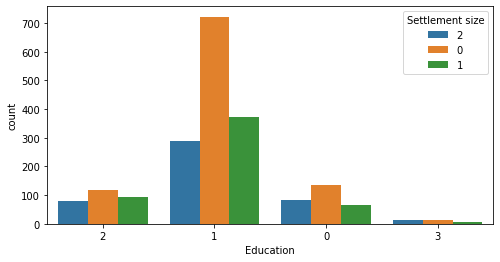

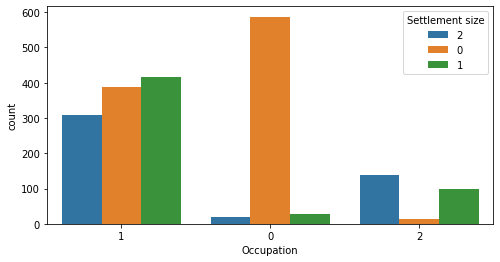

In [13]:
cat_columns_C = cat_columns.copy()
for C1 in cat_columns:
    cat_columns_C.pop(0);
    for C2 in cat_columns_C:
        if C1 != C2:
            plt.figure(figsize=(8,4))
            sns.countplot(data=data, x=C1, hue=C2)



There are a few interesting relationships that can be drawn from the data:

1) People with Occupation = '0' (unemployed) tend to live in small cities within the customers.

2) Married people tend to have either highschool-level or post-graduate-level educations within the customers.

3) Married people also tend to live in smaller cities.

4) Women within the customer list tend to be married more often than men.

5) Males tend to be employed more often within the customer list. Women within the dataset, on the other hand, tend to be unemployed more often


<a id="1"></a> <br>
# 4. Feature Tranformation and Scaling

Age and Income feature have a right-skewed normal distribution. We will have to correct that for the model to perform correctly, since it assumes normality in our features. Most likely, a log transform will correct this skew.

In [14]:
# Normality test for the data by using a normality test from scipy
from scipy.stats.mstats import normaltest

In [15]:
print('The p-value for the null hypothesis of the Age being Normally distributed is: {}'
     .format(normaltest(data.Age)[1]))
print('The p-value for the null hypothesis of the Income being Normally distributed is: {}'
     .format(normaltest(data.Income)[1]))

The p-value for the null hypothesis of the Age being Normally distributed is: 3.3428344869999675e-56
The p-value for the null hypothesis of the Income being Normally distributed is: 2.5009638879187734e-98


The p-value for both features is extremely low and we need to transform the data and check for normallity against the transformed data to add it to the model

In [16]:
# Perform Log Transformation:
data['log_Age'] = np.log1p(data.Age)
data['log_Income'] = np.log1p(data.Income)

In [17]:
# Drop Age & Income columns:
data.drop(['Age','Income'], axis=1,inplace=True)

In [18]:
data.sample(5)

,ID,Sex,Marital status,Education,Occupation,Settlement size,log_Age,log_Income
12,100000013,1,1,1,1,2,3.135494,11.596237
241,100000242,0,0,1,1,1,3.951244,11.661320
608,100000609,0,0,1,1,2,3.526361,11.571345
1278,100001279,0,0,1,2,2,3.583519,11.919976
62,100000063,0,0,2,2,1,4.127134,12.022216


In [19]:
print('The p-value for the null hypothesis of the Age being Normally distributed is: {}'
     .format(normaltest(data.log_Age)[1]))
print('The p-value for the null hypothesis of the Income being Normally distributed is: {}'
     .format(normaltest(data.log_Income)[1]))

The p-value for the null hypothesis of the Age being Normally distributed is: 8.294533638884995e-25
The p-value for the null hypothesis of the Income being Normally distributed is: 9.42013072804996e-08


**p-value for both features its better now.**

<AxesSubplot:>

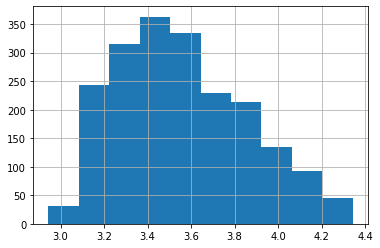

In [20]:
data.log_Age.hist()

<AxesSubplot:>

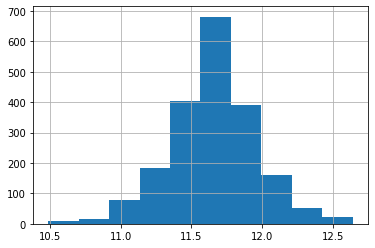

In [21]:
data.log_Income.hist()

**Feature Scaling (MinMaxScaler):**

In [22]:
# Drop ID columns:
data.drop('ID',axis=1, inplace=True)

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(data)

<a id="1"></a> <br>
# 5. Modeling

**K-Means Clustering:**

K-Means is a clustering algorithm based on distance to determine the similarity of different points. It creates clusters by assigning points to the cluster nearest to them.

**Selecting the correct number of clusters using Elbow method:**

In [24]:
from sklearn.cluster import KMeans

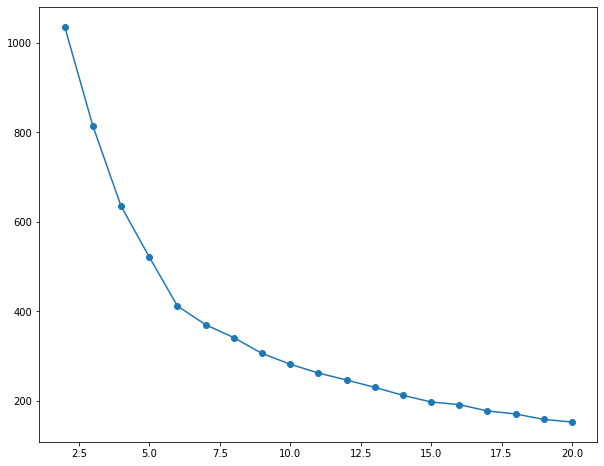

In [25]:
inertia = []
num_cluster = range(2,21)
for num in num_cluster:
    km = KMeans(n_clusters = num, random_state=0)
    km = km.fit(X)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,8))
plt.plot(num_cluster, inertia,marker='o')

When running the loop shown above, we notice that the elbow happens around 6-7 clusters, which would be a good approximation.

**Creating a 3D dataset with PCA:**

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

In [27]:
X_pca_df = pd.DataFrame(X_pca, columns = ['col1','col2','col3'])

**Applying K-Means with 6 clusters and visualizing the results with PCA decomposition:**

In [28]:
km = KMeans(n_clusters=6, random_state=0).fit(X)

In [29]:
# We add the labels of each row to the DataFrame:
labels = km.labels_
X_pca_df['labels'] = labels

In [30]:
X_pca_df.head()

,col1,col2,col3,labels
0,0.829381,0.351232,-0.162877,4
1,-0.531896,0.719313,-0.230636,2
2,0.489748,-0.693175,0.175283,1
3,0.712225,-0.028360,-0.049293,4
4,0.718318,-0.036733,-0.052828,4


In [31]:
X_pca_df['labels'] = X_pca_df['labels'].astype(str)

In [32]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



**Visualization:**

In [33]:
import plotly.express as px

fig = px.scatter_3d(X_pca_df, x='col1', y='col2', z='col3',
              color=X_pca_df['labels'])
fig.show()

We should first notice that the clusters are quite separated and the algorithm seems to be doing the cluster separation well, as the frontiers between clusters seem quite clear.

In [34]:
data['labels'] = km.labels_

In [35]:
data.head()

,Sex,Marital status,Education,Occupation,Settlement size,log_Age,log_Income,labels
0,0,0,2,1,2,4.219508,11.733434,4
1,1,1,1,1,2,3.135494,11.923537,2
2,0,0,1,0,0,3.912023,11.398760,1
3,0,0,1,1,1,3.828641,12.052723,4
4,0,0,1,1,1,3.988984,11.911916,4


**Random Forest as a method to interpret clusters:**

We can make a Random Forest predict the labels of each cluster we have determined:

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [37]:
X = data.drop('labels',axis=1)
y = data.labels

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [39]:
RF = RandomForestClassifier(random_state=42)
RF = RF.fit(X_train,y_train)

**Using GridSearchCV to get best parameters:**

In [40]:
param_grid = { 
    'n_estimators': [25,50,100,200,300,400,500],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

In [41]:
GSC = GridSearchCV(RF, param_grid,cv=5, n_jobs=-1)
GSC = GSC.fit(X_train,y_train)

In [42]:
GSC.best_params_

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 200}

In [43]:
# Create Model:
RF = RandomForestClassifier(n_estimators = 200,max_depth = 6,criterion = 'gini',random_state=42)

In [44]:
RF = RF.fit(X_train,y_train)

In [45]:
y_pred = RF.predict(X_test)

In [46]:
# Measure Function:
def measure(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred),4)
    recall = round(recall_score(y_true, y_pred,average='weighted'),4)
    precision = round(precision_score(y_true, y_pred,average='weighted'),4)
    f1 = round(f1_score(y_true, y_pred,average='weighted'),4)
    return pd.Series({'accuracy_score':accuracy,
                     'recall_score':recall,
                     'precision_score':precision,
                     'f1_score':f1})

In [47]:
measure(y_test, y_pred)

accuracy_score     0.9900
recall_score       0.9900
precision_score    0.9903
f1_score           0.9900
dtype: float64

The model seems extremely accurate at predicting the values of the classes, so we can expect the split points to be quite accurate as well. 